In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import imageio
import cv2
import glob
import os
from shutil import rmtree
from uuid import uuid4
from os import path
from IPython.display import display, clear_output
from PIL import Image, ImageDraw

In [6]:
# pprint(tf.sysconfig.get_build_info())

# print(tf.test.is_built_with_cuda())
# print(tf.test.is_built_with_gpu_support())
import sys
print(sys.executable)

C:\tools\Anaconda3\python.exe


In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPUs detected!")

1 Physical GPUs, 1 Logical GPUs


In [32]:
ignored = {"pje", "lattes", "rfb", "tjrs", "trt3", "nfesjppr"}

input_dir = "dataset"
input_dirs = [f.path for f in os.scandir(input_dir) if f.is_dir() and f.name not in ignored]
rectanglesDir = "rects"

output_dir = "lettersDataset_biggerMargin"

# image_path = glob.glob(os.path.join(input_dirs[0], "*"))[0]




dataset\cadesp\2f3c.png


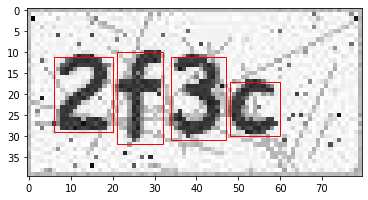

dataset\caixa\1y5nf.gif


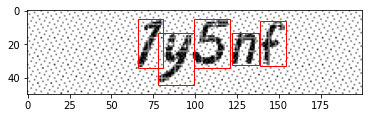

dataset\nfe\09aib.png


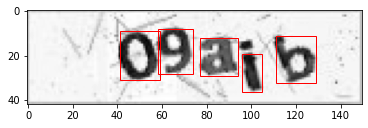

dataset\rsc\2yma.png


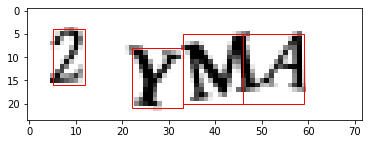

dataset\sefazsp\08p63.jpg


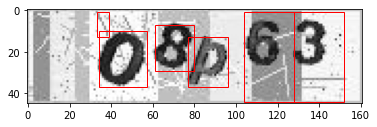

dataset\sintegrarj\2vamr.png


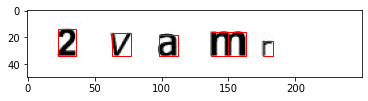

In [27]:
for directory in input_dirs:
    captcha_image_files = glob.glob(os.path.join(directory, "*"))
    
    # for image_path in captcha_image_files:
    image_path = captcha_image_files[301]
    image = cv2.imread(image_path)

    if image is None:
        image = imageio.mimread(image_path)

        # ignore gifs with more than one frame
        if len(image) > 1:
            continue

        # convert form RGB to BGR 
        image = cv2.cvtColor(image[0], cv2.COLOR_RGB2BGR)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # blur = cv2.medianBlur(gray, 1)
    # blur = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, np.ones((2,2), np.uint8))
    tr = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    contours = [ cv2.boundingRect(contour) for contour in cv2.findContours(tr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]]
    contours = [ (x, y, w, h) for (x, y, w, h) in contours if w > 5 and h > 5 and w/h < 3 and h/w < 3]

    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(gray, cmap='gray')

    regions = []

    for (x, y, width, heigth) in contours:
        if width / heigth > 1.05:
            # This contour is too wide to be a single letter!
            # Split it in half into two letter regions!
            half_width = int(width / 2)
            regions.append((x, y, half_width, heigth))
            regions.append((x + half_width, y, half_width, heigth))
        else:
            # This is a normal letter by itself
            regions.append((x, y, width, heigth))

    for (x, y, w, h) in regions:
        ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none'))

    print(image_path)
    plt.show()

In [7]:
def intersectionArea(a, b):
    (x1, y1, w1, h1) = a
    (x2, y2, w2, h2) = b

    dx = min(x1 + w1, x2 + w2) - max(x1, x2)
    dy = min(y1 + h1, y2 + h2) - max(y1, x2)
    if (dx >= 0) and (dy >= 0):
        return dx * dy

In [8]:
def areAnyRegionsOverlapping(regions):
    for (i, region1) in enumerate(regions):
        for (j, region2) in enumerate(regions):
            if i == j:
                continue
            
            area1 = region1[2] * region1[3]
            area2 = region2[2] * region2[3]
            inter = intersectionArea(region1, region2)

            if inter is not None and (area1/inter < 3 or area2/inter < 3):
                return True

    return False


In [9]:
from IPython.display import display, clear_output

failedImages = 0
correctImages = 0

if path.exists(output_dir):
    print("Removing old dataset...")
    rmtree(output_dir)
    print("Removed")

images = [p for p in glob.glob(os.path.join(directory, "*")) for directory in input_dirs]
imageCount = len(images)

for (i, image_path) in enumerate(images):
    # clear_output(wait=True)
    # display('Processing image ' + str(i+1) + ' of ' + str(imageCount) + ' ({:.2f}%)'.format((i+1)/imageCount*100))
    image = cv2.imread(image_path)

    if image is None:
        image = imageio.mimread(image_path)

        # ignore gifs with more than one frame
        if len(image) > 1:
            continue

        # convert form RGB to BGR 
        image = cv2.cvtColor(image[0], cv2.COLOR_RGB2BGR)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # blur = cv2.medianBlur(gray, 1)
    # blur = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, np.ones((2,2), np.uint8))
    tr = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    contours = [ cv2.boundingRect(contour) for contour in cv2.findContours(tr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]]
    contours = [ (x, y, w, h) for (x, y, w, h) in contours if w > 5 and h > 5 and w/h < 3 and h/w < 3]

    regions = []

    for (x, y, width, height) in contours:
        if width < 5 or height < 5 or width/height > 3 or height/width > 3:
            continue

        if width / height > 1.05:
           # This contour is too wide to be a single letter!
           # Split it in half into two letter regions!
           half_width = int(width / 2)
           regions.append((x, y, half_width, height))
           regions.append((x + half_width, y, half_width, height))
        else:
           # This is a normal letter by itself
            regions.append((x, y, width, height))

    regions = sorted(regions, key=lambda x: x[0])

    labels = path.basename(path.splitext(image_path)[0])

    print(labels)

    if (len(labels) != len(regions)):
        failedImages = failedImages + 1
        continue

    if areAnyRegionsOverlapping(regions):
        print("Two regions are overlapping, discarding image")
        continue

    margin = 5
    rectangled = image
    for ((x, y, width, height), label) in zip(regions, labels):
        letter = gray[y - margin:y + height + margin, x - margin:x + width + margin]

        actualHeight, actualWidth = letter.shape

        if len(letter) == 0 or actualWidth == 0 or actualHeight == 0:
            continue

        if max(actualHeight, actualWidth)/min(actualHeight, actualWidth) > 3:
            print("Letter skipped due to invalid aspect ratio")
            continue

        # Get the folder to save the image in
        save_path = os.path.join(output_dir, label)

        # if the output directory does not exist, create it
        if not path.exists(save_path):
            os.makedirs(save_path)

        p = os.path.join(save_path, "{}.png".format(uuid4()))
        
        try:
            cv2.imwrite(p, letter)
            rectangled = cv2.rectangle(rectangled, (x - margin, y - margin), (x + margin + width, y + height + margin), list(np.random.random(size=3) * 256), 1)
        except:
            print("Letter saving failed", p, letter)

    savePath = image_path.replace(input_dir, rectanglesDir)

    if not path.exists(path.dirname(savePath)):
        os.makedirs(path.dirname(savePath))

    try:
        cv2.imwrite(savePath, rectangled)
    except:
        print("Failed to save rectangled image for {}".format(image_path))

    
print("Processed {} images".format(correctImages))
print("Failed to process {} images".format(failedImages))


Removing old dataset...
Removed


KeyboardInterrupt: 